# Exploration of Retinal Cells with AngioTool

### Load data
We need to combine the genotype info with the AngioTool data.


Start by loading the Excel spreadsheet with select columns (we don't care about the date, time, etc.) into a `pandas` DataFrame. 

In [509]:
import numpy as np
import pandas as pd

#tweaked_results = './processed/tweaked/TweakedResults11-6-2017.xls'
tweaked_results = './processed/tweaked/TweakedResults2017-12-4.xls'
data = pd.read_excel(tweaked_results,
                     usecols = "A, G, N, O, Q, S")
## These are the columns from Excel that we're interested in.

Confirm you loaded the correct thing by looking at the header. You can always look at a Dataframe's header through `df.head()`

In [510]:
data.head()

,Image Name,Vessel Thickness,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points
0,35-3b-field 1.tif,9,65.034498,119,14.215480,16
1,35-3b-field 2.tif,9,61.498248,183,16.877167,17
2,35-3b-field 3.tif,9,55.247350,157,15.500902,29
3,35-5b-field 1.tif,10,55.218967,138,14.465886,37
4,35-5-field 2.tif,9,51.731472,134,13.181119,32


### Create unique IDs for each animal
We need to parse the Image Name column in order to get a unique ID for each animal. The unique ID will be used for pairing genotypes using the Genotyping Key document.

I'm using list comprehensions to get Litter/ID info from the Image Name. Both are added to our `data` DataFrame.

In [511]:
data['Litter'] =   [x[:2] for x in data['Image Name']]
data['AnimalID'] = [x[:4] for x in data['Image Name']]

### Load genotyping key
Once again, we'll use the `read_excel` tool found within the `pandas` library.

In [512]:
key = pd.read_excel('genotypingkey.xlsx')
#key

### Obtain entire dataset
We'll merge the two dataframes by using the `merge` function from the `pandas` library. Notice how `AnimalID` is used to match.

We can also drop unneeded columns such as `Image Name`, `ID`, and the duplicated `Litter_y`.

In [513]:
merged_inner = pd.merge(left = data, right = key,
                        how = 'inner',
                        left_on = 'AnimalID',
                        right_on = 'AnimalID'
                       )
## Drop unneeded columns
merged_inner.drop('Litter_y', axis = 1, inplace = True)
merged_inner.drop('ID', axis = 1, inplace = True)
merged_inner.drop('Image Name', axis = 1, inplace = True)
merged_inner.drop('Vessel Thickness', axis = 1, inplace = True)

merged_inner.rename(columns = {'Litter_x':'Litter'},
                    inplace = True)
## Show first five observations
merged_inner

,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points,Litter,AnimalID,Genotype
0,65.034498,119,14.215480,16,35,35-3,+/+
1,61.498248,183,16.877167,17,35,35-3,+/+
2,55.247350,157,15.500902,29,35,35-3,+/+
3,55.218967,138,14.465886,37,35,35-5,DEE/DEE
4,51.731472,134,13.181119,32,35,35-5,DEE/DEE
5,53.907283,125,13.055196,47,35,35-5,DEE/DEE
6,62.635569,148,15.047376,38,36,36-4,DEE/DEE
7,65.269094,169,16.007724,27,36,36-4,DEE/DEE
8,60.138528,113,13.177062,28,36,36-4,DEE/DEE
9,62.868619,87,11.536940,27,36,36-4,DEE/DEE


### Remove heterozygous data

We are comparing wild type and mutant. To make things easier later, let's now remove the heterozygous data using string matching with regular expressions.


In [514]:
# + is a special character. must prepend with \
#het_regex = "DEE/\+" 

#merged_inner = merged_inner[~merged_inner['Genotype']
#                            .str.match(het_regex)]

### Average over Litter and Genotype
Now that we have unblinded our data by assigning genotypes to the various animals, let's pivot by `Genotype` and `Litter` using `set_index()`.

We can also use `sort_index()` to make sure the genotype ordering is consistent for all litters.

Once grouped, we can calculate mean values.

In [515]:
data_mean = (merged_inner
             .set_index(['Litter', 'Genotype']) # pivot
             .sort_index(level = ['Litter', 'Genotype'])
             .mean(level = ['Litter', 'Genotype'])
            )
data_mean

Vessels percentage area  Total Number of Junctions  \
Litter Genotype                                                       
35     +/+                     60.593365                 153.000000   
       DEE/DEE                 53.619241                 132.333333   
36     +/+                     64.298531                 171.666667   
       DEE/DEE                 62.152266                 136.833333   
37     +/+                     58.682159                 110.000000   
       DEE/+                   61.730806                 161.000000   
       DEE/DEE                 54.291983                  98.333333   
40     +/+                     55.955666                 177.000000   
       DEE/+                   51.474604                 111.250000   
       DEE/DEE                 51.083114                 116.400000   
41     +/+                     49.744407                 106.200000   
       DEE/DEE                 49.865152                  91.333333   

                 Total Vessels Length  Total Number of End Points  
Litter Genotype                                                    
35     +/+                  15.531183                   20.666667  
       DEE/DEE              13.567400                   38.666667  
36     +/+                  16.085692                   26.333333  
       DEE/DEE              14.415517                   31.166667  
37     +/+                  13.102471                   25.333333  
       DEE/+                15.673020                   32.500000  
       DEE/DEE              12.666500                   27.666667  
40     +/+                  16.085500                   46.833333  
       DEE/+                12.847697                   32.250000  
       DEE/DEE              13.234076                   34.200000  
41     +/+                  11.683795                   39.800000  
       DEE/DEE              11.323804                   40.666667

### Split data

`data_mean` is a `MultiIndex` object instead of your usual `DataFrame`

In [516]:
data_mean.index

MultiIndex(levels=[['35', '36', '37', '40', '41'], ['+/+', 'DEE/+', 'DEE/DEE']],
           labels=[[0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4], [0, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 2]],
           names=['Litter', 'Genotype'])

We will use `panda`'s cross-section function, `DataFrame.xs`, to separate our data by genotype.

| Wild type | Mutant  |
|-----------|---------|
| +/+       | DEE/DEE |

In [575]:
wild =   data_mean.xs('+/+',     level = 'Genotype')
mutant = data_mean.xs('DEE/DEE', level = 'Genotype')

## Look at the difference in means
diff = wild - mutant
diff

,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points
Litter,,,,
35,6.974125,20.666667,1.963782,-18.000000
36,2.146266,34.833333,1.670175,-4.833333
37,4.390176,11.666667,0.435971,-2.333333
40,4.872553,60.600000,2.851425,12.633333
41,-0.120745,14.866667,0.359991,-0.866667


For fun, we can calculate cohen's $d$ using means and stds. We expect calculating the effect size from the t-statistic to yield identical results.

In [615]:
means = diff.mean()
means

Vessels percentage area        3.652475
Total Number of Junctions     28.526667
Total Vessels Length           1.456269
Total Number of End Points    -2.680000
dtype: float64

In [616]:
stds = diff.std()
stds

Vessels percentage area        2.719007
Total Number of Junctions     20.006921
Total Vessels Length           1.059790
Total Number of End Points    10.922978
dtype: float64

In [621]:
means/stds

Vessels percentage area       1.343312
Total Number of Junctions     1.425840
Total Vessels Length          1.374111
Total Number of End Points   -0.245354
dtype: float64

In [518]:
## Get parameter data arrays
wildVPA =           wild['Vessels percentage area'].values
wildNJunctions =    wild['Total Number of Junctions'].values
wildVesselsLength = wild['Total Vessels Length'].values
wildNEndPoints =    wild['Total Number of End Points'].values

mutantVPA =           mutant['Vessels percentage area'].values
mutantNJunctions =    mutant['Total Number of Junctions'].values
mutantVesselsLength = mutant['Total Vessels Length'].values
mutantNEndPoints =    mutant['Total Number of End Points'].values

## Hypothesis testing

Now that we have our data ready to go, we can do a **paired t-test**.

`scipy` contains useful things for scientific analysis, and they have a built-in paired t-test function called `ttest_rel`.

In [570]:
from scipy import stats

## Do paired/dependent t-tests
t_VPA, p_VPA = stats.ttest_rel(wildVPA, mutantVPA)

t_n_junct, p_n_junct = stats.ttest_rel(
    wildNJunctions, mutantNJunctions)

t_vessel_length, p_vessel_length = stats.ttest_rel(
    wildVesselsLength, mutantVesselsLength)

t_n_endpoints, p_n_endpoints = stats.ttest_rel(
    wildNEndPoints, mutantNEndPoints)

t_statistics = [t_VPA, t_n_junct, t_vessel_length, t_n_endpoints]
p_values =     [p_VPA, p_n_junct, p_vessel_length, p_n_endpoints]

stat_df = pd.DataFrame({'Parameter': wild.columns,
                        't_statistic': t_statistics, 
                        'p_value': p_values})

stat_df.set_index('Parameter')

,p_value,t_statistic
Parameter,,
Vessels percentage area,0.039795,3.003737
Total Number of Junctions,0.033271,3.188275
Total Vessels Length,0.037198,3.072606
Total Number of End Points,0.612444,-0.548629


It appears that our p-values for 
- `Vessels percentage area` 
- `Total Number of Junctions`
- `Total Vessels Length`

are statistically significant at the p < 0.05 level.

However, p-values by themselves aren't very useful. Sure, there's indication of a statistically significant result, but what sort of a difference does it make?

To answer this, we can look at **effect size**.

"Cohen's d" is frequently seen among literature, but there are a handful of techniques that are mistakenly attributed to be Cohen's d. For a good review, I recommend https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3840331/.

In this analysis, we will use Cohen's $d_z$, where the $z$ reminds us that we are looking at the difference of two samples ($x$ and $y$).



In [585]:
## Calculate Cohen's d using test statistic and n
## https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3840331/
def get_cohens_d_z(t_statistic, n):
    """Returns Cohen's d_z
    
    One way of calculating Cohen's d is by 
    taking the t-statistic and dividing it by
    the square root of the sample size.
    """
    d = [t / np.sqrt(n)
         for t in t_statistic]
    
    return d

n = len(wildVPA)

cohens_d_values = get_cohens_d(t_statistics, n)

stat_df['cohen_dz'] = cohens_d_values
stat_df.set_index('Parameter')

,p_value,t_statistic,cohen_dz
Parameter,,,
Vessels percentage area,0.039795,3.003737,1.343312
Total Number of Junctions,0.033271,3.188275,1.425840
Total Vessels Length,0.037198,3.072606,1.374111
Total Number of End Points,0.612444,-0.548629,-0.245354


## Effect size results
The Cohen d$_z$ values indicate that our effect sizes are on the order of 1.4$\sigma$.

There's some concern that Cohen's d is biased upwards for small samples (n < 20)

### Exploratory plots

QQ plots, etc. to follow after we have more than three data points per plot.


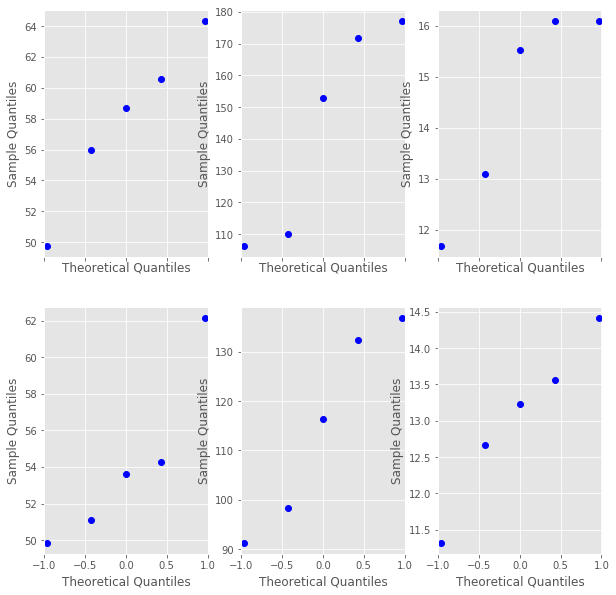

In [604]:
#from scipy import stats
import statsmodels.api as sm

wild_data = [wildVPA, wildNJunctions, wildVesselsLength]
mutant_data = [mutantVPA, mutantNJunctions, mutantVesselsLength]

plt.close()
fig, axes = plt.subplots(2, 3, figsize=(10,10),sharex=True)
ax = axes.ravel()
for i, (wild_var, mutant_var) in enumerate(
    list(zip(wild_data, mutant_data))):
    
    sm.graphics.qqplot(data=wild_var, ax=ax[i])
    sm.graphics.qqplot(data=mutant_var, ax=ax[i+3])
#stats.probplot(wildVPA, plot=ax[0])
plt.show()

## Boxplots for different parameters

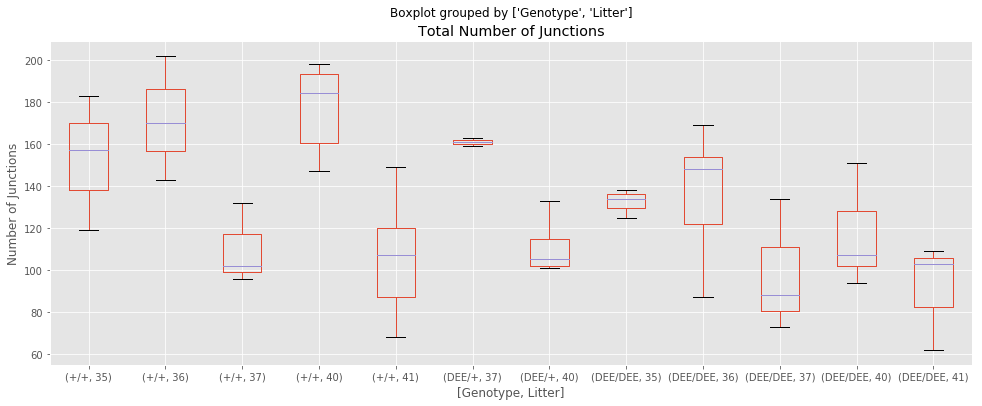

In [605]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

merged_inner.boxplot(column = ['Total Number of Junctions'],
                     by = ['Genotype', 'Litter'],
                     figsize = (16,6)
                    )
plt.ylabel('Number of Junctions')
plt.show()

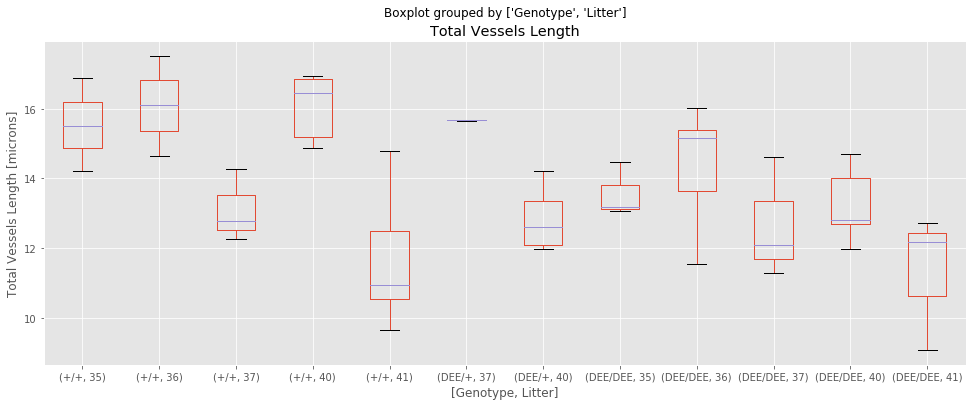

In [525]:
merged_inner.boxplot(column = ['Total Vessels Length'],
                     by = ['Genotype', 'Litter'],
                     figsize = (16,6)
                    )
plt.ylabel('Total Vessels Length [microns]')
plt.show()

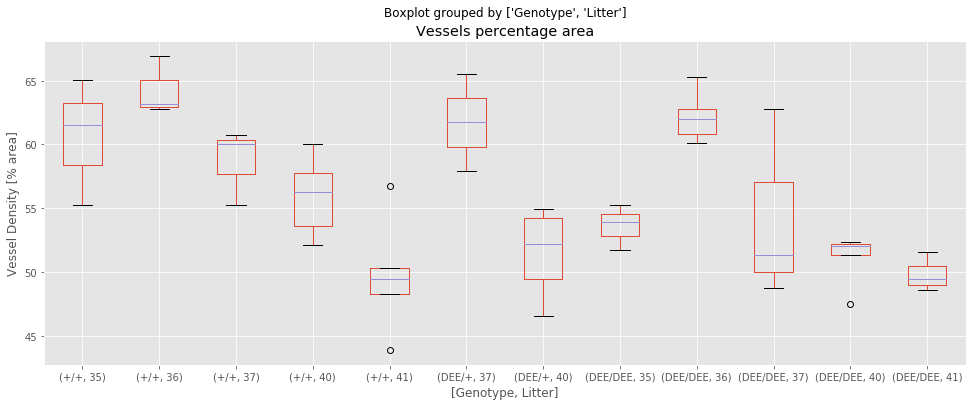

In [526]:
merged_inner.boxplot(column = ['Vessels percentage area'],
                     by = ['Genotype', 'Litter'],
                     figsize = (16,6)
                    )
plt.ylabel('Vessel Density [% area]')
plt.show()

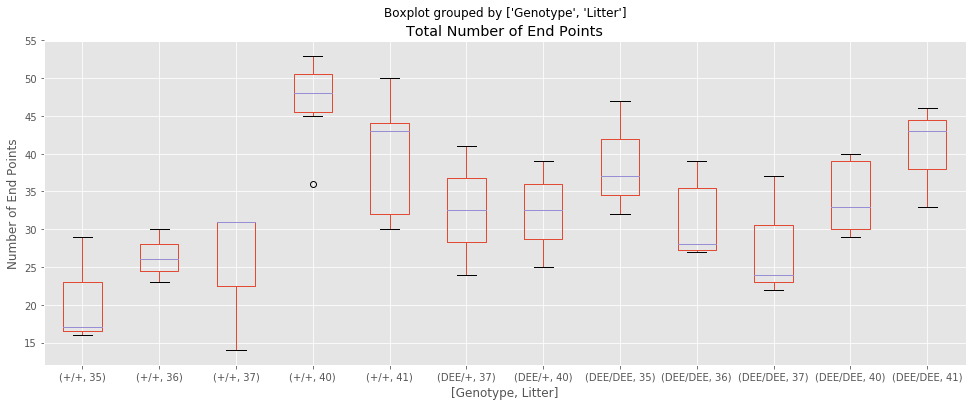

In [527]:
merged_inner.boxplot(column = ['Total Number of End Points'],
                     by = ['Genotype', 'Litter'],
                     figsize = (16,6)
                    )
plt.ylabel('Number of End Points')
plt.show()

## Comparison in Percentages
The below table represents the percentage of mutant to wild type

In [528]:
normdata = ((mutant / wild.values * 100)
            .rename(
                columns={
                    'Vessels percentage area':'norm Vessels Density',
                    'Total Number of Junctions':'norm Number of Junctions',
                    'Total Vessels Length':'norm Vessels Length',
                    'Total Number of End Points':'norm Number of End Points'}
                    )
            )

#normdata.drop('Genotype', axis=0, level=1, inplace=True)
#normdata.drop('Vessel Thickness', axis=0, level=1,inplace=True)
normdata[['norm Vessels Density','norm Number of Junctions', 'norm Vessels Length', 'norm Number of End Points']]

,norm Vessels Density,norm Number of Junctions,norm Vessels Length,norm Number of End Points
Litter,,,,
35,88.490284,86.492375,87.355873,187.096774
36,96.662030,79.708738,89.617015,118.354430
37,92.518721,89.393939,96.672603,109.210526
40,91.292119,65.762712,82.273324,73.024911
41,100.242731,86.001255,96.918887,102.177554


## Mean and std for different variables in different litters

If you want to look at the numbers after averaging, here they are.

In [529]:
(merged_inner.groupby(['Litter', 'Genotype'])
                     ['Total Number of End Points']
                     .describe()
)

count       mean        std   min    25%   50%    75%   max
Litter Genotype                                                             
35     +/+         3.0  20.666667   7.234178  16.0  16.50  17.0  23.00  29.0
       DEE/DEE     3.0  38.666667   7.637626  32.0  34.50  37.0  42.00  47.0
36     +/+         3.0  26.333333   3.511885  23.0  24.50  26.0  28.00  30.0
       DEE/DEE     6.0  31.166667   5.706721  27.0  27.25  28.0  35.50  39.0
37     +/+         3.0  25.333333   9.814955  14.0  22.50  31.0  31.00  31.0
       DEE/+       2.0  32.500000  12.020815  24.0  28.25  32.5  36.75  41.0
       DEE/DEE     3.0  27.666667   8.144528  22.0  23.00  24.0  30.50  37.0
40     +/+         6.0  46.833333   6.013873  36.0  45.50  48.0  50.50  53.0
       DEE/+       4.0  32.250000   6.075909  25.0  28.75  32.5  36.00  39.0
       DEE/DEE     5.0  34.200000   5.069517  29.0  30.00  33.0  39.00  40.0
41     +/+         5.0  39.800000   8.497058  30.0  32.00  43.0  44.00  50.0
       DEE/DEE     3.0  40.666667   6.806859  33.0  38.00  43.0  44.50  46.0

In [530]:
(merged_inner.groupby(['Litter', 'Genotype'])
                     ['Vessels percentage area']
                     .describe()
)

count       mean       std        min        25%        50%  \
Litter Genotype                                                                
35     +/+         3.0  60.593365  4.955923  55.247350  58.372799  61.498248   
       DEE/DEE     3.0  53.619241  1.761499  51.731472  52.819378  53.907283   
36     +/+         3.0  64.298531  2.311205  62.807058  62.967370  63.127682   
       DEE/DEE     6.0  62.152266  1.864851  60.138528  60.834866  61.984257   
37     +/+         3.0  58.682159  2.958607  55.290481  57.656938  60.023394   
       DEE/+       2.0  61.730806  5.383032  57.924427  59.827617  61.730806   
       DEE/DEE     3.0  54.291983  7.470105  48.762370  50.042961  51.323552   
40     +/+         6.0  55.955666  3.043800  52.121967  53.629821  56.268386   
       DEE/+       4.0  51.474604  3.824678  46.527358  49.461297  52.217599   
       DEE/DEE     5.0  51.083114  2.037698  47.504211  51.336465  52.037516   
41     +/+         5.0  49.744407  4.640998  43.896302  48.296066  49.424590   
       DEE/DEE     3.0  49.865152  1.517273  48.598642  49.024340  49.450038   

                       75%        max  
Litter Genotype                        
35     +/+       63.266373  65.034498  
       DEE/DEE   54.563125  55.218967  
36     +/+       65.044268  66.960854  
       DEE/DEE   62.810357  65.269094  
37     +/+       60.377998  60.732602  
       DEE/+     63.633995  65.537184  
       DEE/DEE   57.056789  62.790027  
40     +/+       57.758066  60.070332  
       DEE/+     54.230907  54.935861  
       DEE/DEE   52.184838  52.352538  
41     +/+       50.331407  56.773672  
       DEE/DEE   50.498408  51.546778

In [531]:
(merged_inner.groupby(['Litter', 'Genotype'])
                     ['Total Number of Junctions']
                     .describe()
)

count        mean        std    min     25%    50%     75%  \
Litter Genotype                                                               
35     +/+         3.0  153.000000  32.186954  119.0  138.00  157.0  170.00   
       DEE/DEE     3.0  132.333333   6.658328  125.0  129.50  134.0  136.00   
36     +/+         3.0  171.666667  29.535290  143.0  156.50  170.0  186.00   
       DEE/DEE     6.0  136.833333  30.668659   87.0  121.75  148.0  154.00   
37     +/+         3.0  110.000000  19.287302   96.0   99.00  102.0  117.00   
       DEE/+       2.0  161.000000   2.828427  159.0  160.00  161.0  162.00   
       DEE/DEE     3.0   98.333333  31.785741   73.0   80.50   88.0  111.00   
40     +/+         6.0  177.000000  21.494185  147.0  160.50  184.0  193.25   
       DEE/+       4.0  111.250000  14.930394  101.0  101.75  105.5  115.00   
       DEE/DEE     5.0  116.400000  23.071628   94.0  102.00  107.0  128.00   
41     +/+         5.0  106.200000  31.027407   68.0   87.00  107.0  120.00   
       DEE/DEE     3.0   91.333333  25.579940   62.0   82.50  103.0  106.00   

                   max  
Litter Genotype         
35     +/+       183.0  
       DEE/DEE   138.0  
36     +/+       202.0  
       DEE/DEE   169.0  
37     +/+       132.0  
       DEE/+     163.0  
       DEE/DEE   134.0  
40     +/+       198.0  
       DEE/+     133.0  
       DEE/DEE   151.0  
41     +/+       149.0  
       DEE/DEE   109.0

In [532]:
(merged_inner.groupby(['Litter', 'Genotype'])
                     ['Total Vessels Length']
                     .describe()
)

count       mean       std        min        25%        50%  \
Litter Genotype                                                                
35     +/+         3.0  15.531183  1.331102  14.215480  14.858191  15.500902   
       DEE/DEE     3.0  13.567400  0.780655  13.055196  13.118157  13.181119   
36     +/+         3.0  16.085692  1.441889  14.639636  15.366850  16.094064   
       DEE/DEE     6.0  14.415517  1.706224  11.536940  13.644641  15.169351   
37     +/+         3.0  13.102471  1.049104  12.258290  12.515215  12.772140   
       DEE/+       2.0  15.673020  0.020813  15.658303  15.665662  15.673020   
       DEE/DEE     3.0  12.666500  1.740829  11.292903  11.687607  12.082311   
40     +/+         6.0  16.085500  0.976481  14.881495  15.195534  16.458088   
       DEE/+       4.0  12.847697  1.030618  11.960456  12.097356  12.611472   
       DEE/DEE     5.0  13.234076  1.088711  11.988895  12.696118  12.792498   
41     +/+         5.0  11.683795  2.018550   9.637989  10.553913  10.941220   
       DEE/DEE     3.0  11.323804  1.964719   9.075839  10.629421  12.183002   

                       75%        max  
Litter Genotype                        
35     +/+       16.189034  16.877167  
       DEE/DEE   13.823503  14.465886  
36     +/+       16.808720  17.523376  
       DEE/DEE   15.397337  16.007724  
37     +/+       13.524562  14.276983  
       DEE/+     15.680379  15.687737  
       DEE/DEE   13.353298  14.624286  
40     +/+       16.858037  16.949296  
       DEE/+     13.361813  14.207391  
       DEE/DEE   14.006124  14.686744  
41     +/+       12.500906  14.784946  
       DEE/DEE   12.447786  12.712570

### Potentially useful snippets for the future

In [535]:
idx = pd.IndexSlice
data_mean.index

MultiIndex(levels=[['35', '36', '37', '40', '41'], ['+/+', 'DEE/+', 'DEE/DEE']],
           labels=[[0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4], [0, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 2]],
           names=['Litter', 'Genotype'])

In [536]:
# equivalent to data_mean.query('Genotype == "+/+"')
#data_mean.loc[idx[:,'+/+'],:]  

In [538]:
diffdata = ((wild.values - mutant)
            .rename(
                columns={
                    'Vessels percentage area':'diff Vessels percentage area',
                    'Total Number of Junctions':'diff Number of Junctions',
                    'Total Vessels Length':'diff Vessels Length',
                    'Total Number of End Points':'diff Number of End Point'}
                    )
            )


diffdata

,diff Vessels percentage area,diff Number of Junctions,diff Vessels Length,diff Number of End Point
Litter,,,,
35,6.974125,20.666667,1.963782,-18.000000
36,2.146266,34.833333,1.670175,-4.833333
37,4.390176,11.666667,0.435971,-2.333333
40,4.872553,60.600000,2.851425,12.633333
41,-0.120745,14.866667,0.359991,-0.866667


In [539]:
diffdata.mean()

diff Vessels percentage area     3.652475
diff Number of Junctions        28.526667
diff Vessels Length              1.456269
diff Number of End Point        -2.680000
dtype: float64

In [540]:
diffdata.std()

diff Vessels percentage area     2.719007
diff Number of Junctions        20.006921
diff Vessels Length              1.059790
diff Number of End Point        10.922978
dtype: float64

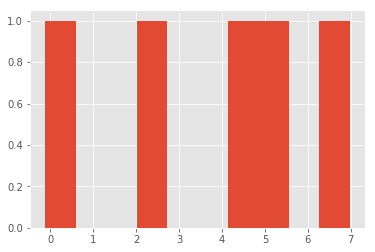

In [541]:
diffdata['diff Vessels percentage area'].hist()
plt.show()

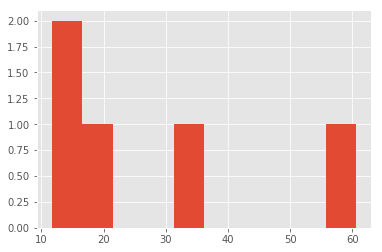

In [542]:
diffdata['diff Number of Junctions'].hist()
plt.show()

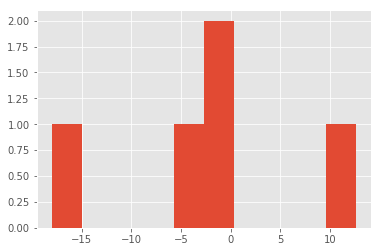

In [543]:
diffdata['diff Number of End Point'].hist()
plt.show()

In [ ]:
diffdata['diff Vessels Length'].hist()
plt.show()

In [ ]:
#
#def get_unbiased_d(cohens_d, n):
#    """Returns an unbiased estimator of effect size
#    
#    Cohen's d is biased upwards for small sample size.
#    Hedges and Olkin (1985) suggested a correction to
#    Cohen's d.
#    """
#    d_unbiased = [d * (1 - 3/(4*(n - 2) - 1))
#                 for d in cohens_d]
#    
#    return d_unbiased

#def other_d(t_statistic, n):
#    other_d = [2*t / np.sqrt(n-2)
#              for t in t_statistic]
    
#    return other_d

#def another_d(t_statistic, n):
#    another_d = [np.sqrt(2) * t / np.sqrt(n-1)
#                for t in t_statistic]
    
#    return another_d

#print(other_d(t_statistics, n))


#unbiashed_d_values = get_unbiased_d(cohens_d_values, n)
#other_d_values = other_d(t_statistics, n)
#another_d_values = another_d(t_statistics, n)

#rounded_cohens = list(map(lambda x: np.round(x,1), cohens_d_values))
#print('cohens d:')
#print(cohens_d_values)
#print(["{:f}".format([print(d) for d in cohens_d_values])])
#print('unbiased d:')
#print(unbiashed_d_values)
#print('other d:')
#print(other_d_values)
#print('another d:')
#print(another_d_values)